In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tf-models-official

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR = "drive/MyDrive/dataset"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  800
file train/nonfight: 800
file val/fight:  200
file val/nonfight:  200


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        else:
            video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            # label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0
        return data

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (21, 224, 224, 3)
Label: 1


In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=3)
  return embed.embed_file('./animation.gif')


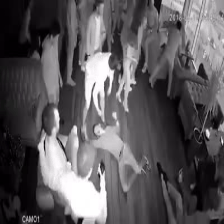

In [ ]:
to_gif(frames)

In [ ]:
# buat tf.data.Dataset
batch_size = 8
num_frames = 21

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)

In [ ]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor([0 0 0 0 0 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 0 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 0 1 1 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 1 0 0 1 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 1 0 0 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 0 0 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 1 1 0 0 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 1 1 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 0 0 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 0 1 1 0 0], shape=(8,), dtype=int16)
Shape: (8, 21, 224, 224, 3)
Label: (8,)


In [ ]:
def plot_history(history):



  # Plot training & validation accuracy values
  plt.figure(figsize=(14, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

In [ ]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
# backbone.trainable = False
backbone.trainable = True

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# # Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

print()

for layer in backbone.layers:
  print(layer.name, layer.trainable)



image True
movinet True
classifier_head True

inputs True
stem True
block0_layer0 True
block1_layer0 True
block1_layer1 True
block1_layer2 True
block2_layer0 True
block2_layer1 True
block2_layer2 True
block3_layer0 True
block3_layer1 True
block3_layer2 True
block3_layer3 True
block4_layer0 True
block4_layer1 True
block4_layer2 True
block4_layer3 True
head True


In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.summary()
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 2)

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [ ]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

In [ ]:
num_epochs = 10

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss_obj, optimizer='Adam', metrics=['accuracy'])

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/10
200/200 [==============================] - 138s 296ms/step - loss: 0.3865 - accuracy: 0.8344 - val_loss: 0.3848 - val_accuracy: 0.8275
Epoch 2/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2009 - accuracy: 0.9175 - val_loss: 0.9462 - val_accuracy: 0.7900
Epoch 3/10
200/200 [==============================] - 39s 194ms/step - loss: 0.1389 - accuracy: 0.9494 - val_loss: 0.5729 - val_accuracy: 0.8025
Epoch 4/10
200/200 [==============================] - 39s 194ms/step - loss: 0.1222 - accuracy: 0.9500 - val_loss: 0.4631 - val_accuracy: 0.8775
Epoch 5/10
200/200 [==============================] - 39s 194ms/step - loss: 0.0992 - accuracy: 0.9675 - val_loss: 0.5592 - val_accuracy: 0.8625
Epoch 6/10
200/200 [==============================] - 39s 194ms/step - loss: 0.0737 - accuracy: 0.9706 - val_loss: 1.1100 - val_accuracy: 0.7925
Epoch 7/10
200/200 [==============================] - 39s 194ms/step - loss: 0.0638 - accuracy: 0.9756 - val_loss: 3.4717 - val_a

In [ ]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 3s 64ms/step - loss: 0.7161 - accuracy: 0.8600


{'loss': 0.7161282896995544, 'accuracy': 0.8600000143051147}

In [ ]:
import seaborn as sns

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:

label_names = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')

50/50 [==============================] - 17s 70ms/step
